In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle
import re, sys, unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import scikitplot as skplt

# Representation

#plt.style.use('fivethirtyeight')

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'
features_path = root_path + 'data/features/data_tfid_hash28_n10000.p'


delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [3]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [4]:
train_fraction = 0.8

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]

In [5]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1.4) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)


In [6]:
set(weights_train)

{0.268272550941509,
 0.2746997280190859,
 0.9153109481707647,
 1.019595433968399,
 5.286210239735423,
 7.445978173727012,
 8.04906686411735,
 23.719311597066106}

In [7]:
labels

y_train_new = []
for yTmp in y_train:
    for idx, label in enumerate(labels):
        if yTmp==label: 
            y_train_new.append(idx)
            
y_test_new = []
for yTmp in y_test:
    for idx, label in enumerate(labels):
        if yTmp==label: 
            y_test_new.append(idx)            


# Model



In [8]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train_new, weight= weights_train)
#lgb_train = lgb.Dataset(X_train, y_train_new)
lgb_eval = lgb.Dataset(X_test, y_test_new, reference=lgb_train)


In [9]:
# specify your configurations as a dict
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'num_class':nClasses,
#     'metric' : "multi_logloss",
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 1,
#     #'
# }

# leave 31 def
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':nClasses,
    'metric': 'multi_logloss',
    'learning_rate': 0.4,#0.4
    'min_data_in_leaf':50, #60 ,50     
    'max_depth':-1,
    'num_leaves': 71,#31 , 71
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': -1,
    'verbose': 1,    
    'num_threads':40}

start = time.time()
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=6,
                )

end = time.time()
print("training time :" + str(end - start) )

Start training...
[1]	valid_0's multi_logloss: 1.37469
Training until validation scores don't improve for 6 rounds.
[2]	valid_0's multi_logloss: 1.13858
[3]	valid_0's multi_logloss: 0.989192
[4]	valid_0's multi_logloss: 0.881208
[5]	valid_0's multi_logloss: 0.799987
[6]	valid_0's multi_logloss: 0.736146
[7]	valid_0's multi_logloss: 0.679216
[8]	valid_0's multi_logloss: 0.634057
[9]	valid_0's multi_logloss: 0.599632
[10]	valid_0's multi_logloss: 0.566441
[11]	valid_0's multi_logloss: 0.53833
[12]	valid_0's multi_logloss: 0.512514
[13]	valid_0's multi_logloss: 0.49165
[14]	valid_0's multi_logloss: 0.471105
[15]	valid_0's multi_logloss: 0.456763
[16]	valid_0's multi_logloss: 0.440273
[17]	valid_0's multi_logloss: 0.427783
[18]	valid_0's multi_logloss: 0.416174
[19]	valid_0's multi_logloss: 0.405014
[20]	valid_0's multi_logloss: 0.396519
[21]	valid_0's multi_logloss: 0.386172
[22]	valid_0's multi_logloss: 0.378183
[23]	valid_0's multi_logloss: 0.370668
[24]	valid_0's multi_logloss: 0.36338

# performance


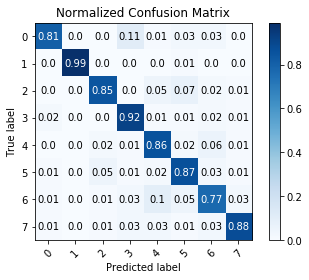

## Accuracy in test: 90.78594757557994 

In [10]:
import scikitplot as skplt

preds =  gbm.predict(X_test)
predictions = []
for x in preds:
    predictions.append(np.argmax(x))
    
y_test_hat = predictions


skplt.metrics.plot_confusion_matrix(y_test_new, y_test_hat,normalize=True)
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_true=y_test_new, y_pred=y_test_hat)

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

In [11]:
# preds =  gbm.predict(X_test)
# predictions = []
# for x in preds:
#     predictions.append(np.argmax(x))
    
# y_test_hat = predictions


# skplt.metrics.plot_confusion_matrix(y_test_new, y_test_hat,normalize=True)
# plt.xticks(rotation=45)
# plt.show()

# acc = accuracy_score(y_true=y_test_new, y_pred=y_test_hat)

# #print('Accuracy in test: {}'.format(acc))
# display(Markdown('## Accuracy in test: {} '.format(acc*100)))

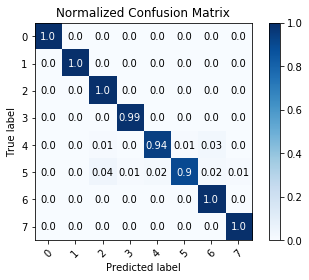

## Accuracy in test: 96.0089817538497 

In [12]:
import scikitplot as skplt

preds =  gbm.predict(X_train)
predictions = []
for x in preds:
    predictions.append(np.argmax(x))
    
y_train_hat = predictions


skplt.metrics.plot_confusion_matrix(y_train_new, y_train_hat,normalize=True)
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_true=y_train_new, y_pred=y_train_hat)

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))